# Análise da resposta ao impulso obtida no estúdio da Paula

## Dependências e funções auxiliares

In [1]:
%matplotlib inline 
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft, fftshift, ifftshift
from scipy.io.wavfile import read as audioread
import seaborn as sns
import IPython
import scipy.signal

In [4]:
def getFrequenciesVector (signal, fs=44100):
    f = np.linspace(0, fs, len(signal))
    
    return f

def getTimeVector (signal, fs=44100):
    t = np.linspace(0, len(signal)/fs, len(signal))
    
    return t

def toDB (signal):
    return 20 * np.log10(signal)

def normalize (signal):
    maxValue = max(abs(signal))
    return signal / maxValue

def magnitudeAndPhase (signal):
    signalInFreqDomain = fft(fftshift(signal))
    return np.abs(signalInFreqDomain), np.unwrap(np.angle(signalInFreqDomain))

def plotSignalInFreqDomain (signal, fs=44100, xscale=[20, 20e3], ylabel="", title=""):
    frequencies = getFrequenciesVector(signal, fs)
    plt.plot(frequencies, signal)
    plt.xlim(xscale)
    plt.ylabel(ylabel)
    plt.xlabel("Frequência (Hz)")
    plt.title(title)
    plt.show()
    
def plotSignalInTimeDomain (signal, fs=44100, title="Forma de onda"):
    timeVector = getTimeVector(signal, fs)
    plt.plot(timeVector, normalize(signal))
    plt.xlabel("Tempo (s)")
    plt.ylabel("Amplitude normalizada")
    plt.title(title)
    plt.show()

def plotMagnitude (signal, fs=44100, xscale=[20, 20e3], ylabel="Magnitude (dB)", title="Magnitude"):
    signalMagnitude, _ = magnitudeAndPhase(signal)
    plotSignalInFreqDomain(toDB(signalMagnitude), fs, xscale, ylabel, title)
    
def plotGroupDelay (signal, fs=44100, xscale=[20, 20e3], ylabel="Atraso de grupo (ms)", title="Atraso de grupo"):
    frequencies = getFrequenciesVector(signal, fs)
    
    _, signalPhase = magnitudeAndPhase (signal)
    phaseDelay = signalPhase
    groupDelay = -(np.diff(phaseDelay, 1) / (2*np.pi)) * 1000
    
    plotSignalInFreqDomain(np.pad(groupDelay, (0,1), 'constant'), fs, xscale, ylabel, title)

def plotWelch (signal, fs=44100, xscale=[20, 20e3], ylabel="Decibeis (dB)", title="Densidade espectral"):
    _, periodogram = scipy.signal.welch(signal, fs, scaling='spectrum')
    
    plotSignalInFreqDomain(toDB(periodogram), fs, xscale, ylabel, title)
    
def playSignal (signal, fs=44100, label=""):
    audioPlayer = IPython.display.Audio(data=normalize(signal), rate=fs)
    displayedLabel = IPython.display.Markdown(label)
    IPython.display.display(displayedLabel, audioPlayer)
    
def showSignalInfo (signal, fs=44100, signalName="", xscale=[20, 20e3]):
    playSignal(signal, fs, signalName)
    plotSignalInTimeDomain(signal, fs)
    plotGroupDelay(signal, fs, xscale)
    plotWelch(signal, fs, xscale)
    plotMagnitude(signal, fs, xscale)

## Obtenção da resposta ao impulso

TSP sintetizado:

TSP

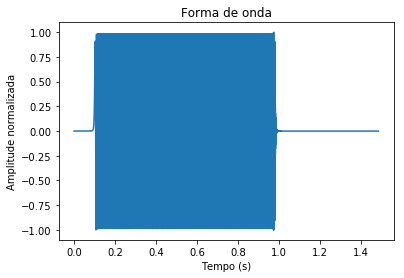

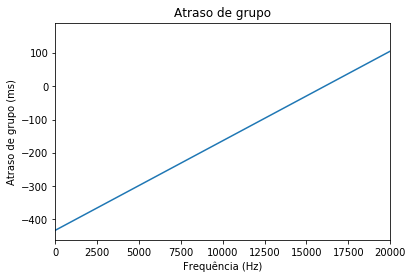

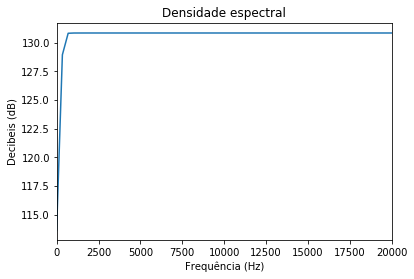

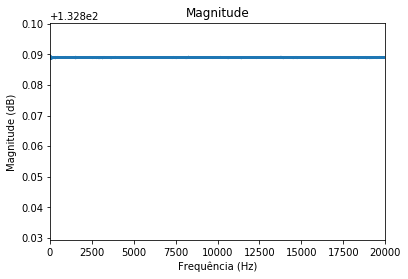

In [5]:
(fs, tsp) = audioread("../tsp1s.wav")
showSignalInfo(tsp, fs, signalName="TSP")

Resposta ao TSP gravada no estúdio:

Recorded room response

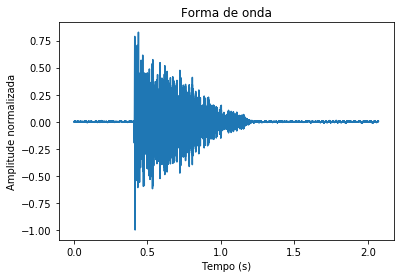

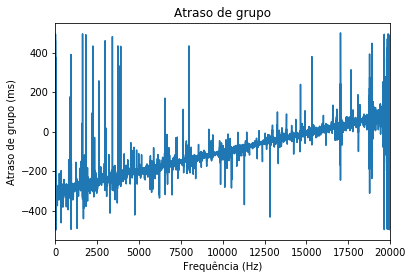

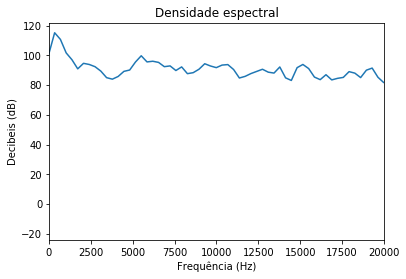

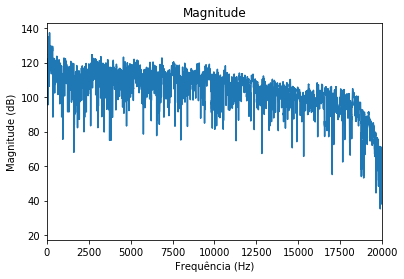

In [7]:
(fs, recorded) = audioread("../tspin-16.wav")
#recorded = normalize(recorded)
showSignalInfo(recorded, fs, signalName="Recorded room response")

Resposta ao impulso obtida pela simples divisão dos sinais no domínio da frequência, truncada para ter o mesmo comprimento que o TSP sintetizado:

In [8]:
def fftDeconvolve (kernel, signal):
    # pad signals
    lengthToPad = len(kernel) + len(signal) - 1
    paddedKernel = np.pad(kernel, (0, lengthToPad - len(kernel)), 'constant')
    paddedSignal = np.pad(signal, (0, lengthToPad - len(signal)), 'constant')
    
    kernelFFT = fft(paddedKernel)
    signalFFT = fft(paddedSignal)
    
    # naïve deconvolution
    deconvolved = signalFFT / kernelFFT
    return np.real(ifft(deconvolved))

Room impulse response

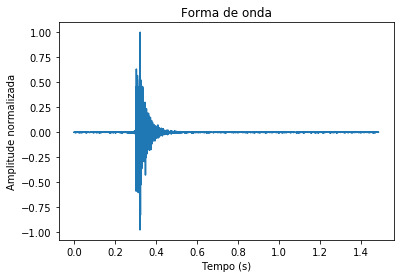

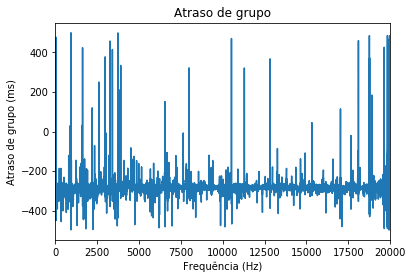

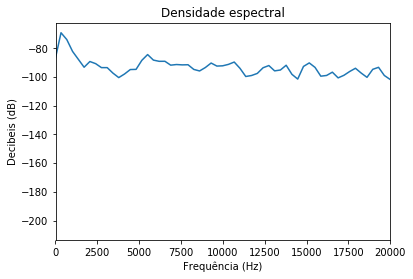

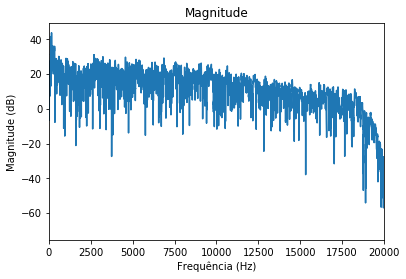

In [9]:
ir = fftDeconvolve(tsp, recorded)
ir = normalize(ir)[:len(tsp)] # truncate the IR
showSignalInfo(ir, signalName="Room impulse response")

## Filtragem inversa através da resposta ao impulso

Foram tentadas quatro abordagens distintas para a realização da filtragem inversa. Primeiramente, tentou-se simplesmente deconvoluir a resposta ao impulso obtida do TSP sintetizado originalmente, usando novamente a divisão simples dos sinais. Nota-se a extrema distorção no sinal de saída:

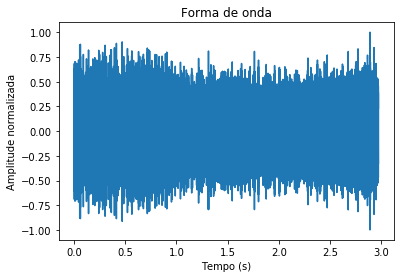

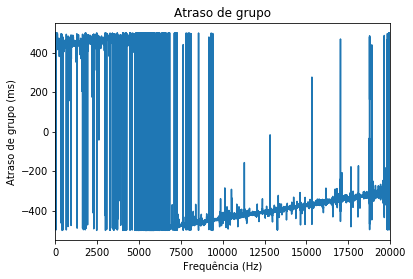

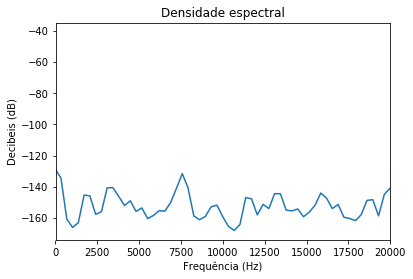

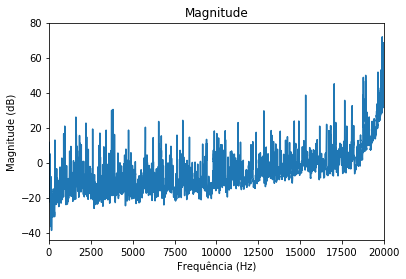

In [10]:
resultByNaiveDivision = normalize(fftDeconvolve(ir, tsp))
showSignalInfo(resultByNaiveDivision)

Em seguida, buscando-se preservar a resposta de fase do sinal original em detrimento da fidelidade do filtro inverso, buscou-se dividir apenas a magnitude dos sinais envolvidos, sem que fosse alterada a fase:

In [11]:
def divideMagnitudes (kernel, signal):
    # zero-padding
    lengthToPad = len(kernel) + len(signal) - 1
    paddedKernel = np.pad(kernel, (0, lengthToPad - len(kernel)), 'constant')
    paddedSignal = np.pad(signal, (0, lengthToPad - len(signal)), 'constant')
    
    signalFFT = fft(paddedSignal)
    kernelFFT = fft(paddedKernel)
    magnitudeDivisor = abs(kernelFFT)**2 # square of the ir's magnitude response
    deconvolved = signalFFT / magnitudeDivisor
    
    # applying a bit of gain to the deconvolved signal
    scalingFactor = max(abs(signalFFT))
    return np.real(ifft(deconvolved * scalingFactor))

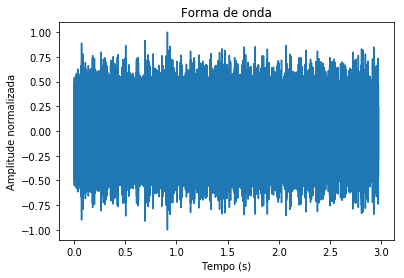

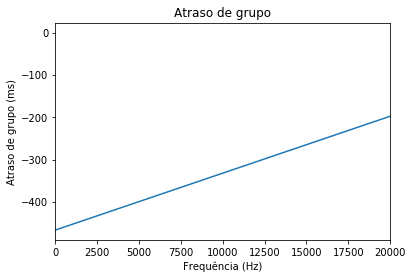

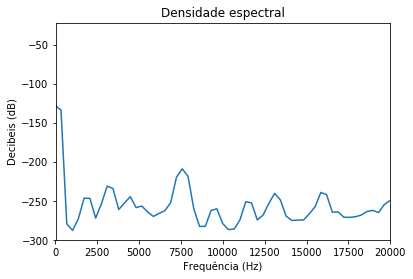

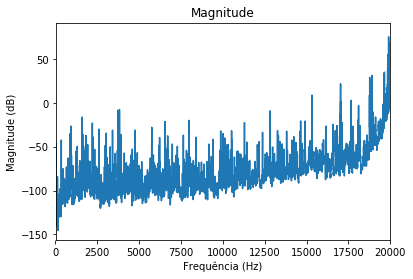

In [12]:
resultByMagnitudeDivision = normalize(divideMagnitudes(ir, tsp))
showSignalInfo(resultByMagnitudeDivision)

Supondo-se a distorção harmônica do resultado proveniente de zeros na resposta ao impulso obtida, buscou-se então "regularizar" a deconvolução. Essa regularização foi feita substituindo por zeros os pontos da resposta em frequência nos quais o valor absoluto da magnitude da resposta se encontra abaixo de um determinado limiar. Este limiar foi determinado empiricamente analisando a resposta em frequência obtida.

In [13]:
def regularizedDivision (x, y, threshold):
    return x/y if abs(y) > threshold else 0

def regularizedDeconvolution (kernel, signal, threshold = 1):
    # zero-padding
    lengthToPad = len(kernel) + len(signal) - 1
    paddedKernel = np.pad(kernel, (0, lengthToPad - len(kernel)), 'constant')
    paddedSignal = np.pad(signal, (0, lengthToPad - len(signal)), 'constant')
    
    signalFFT = fft(paddedSignal)
    kernelFFT = fft(paddedKernel)
    deconvolved = np.array([regularizedDivision(signalFFT[i], kernelFFT[i], threshold) for i in range(lengthToPad)])
    
    return np.real(ifft(deconvolved))

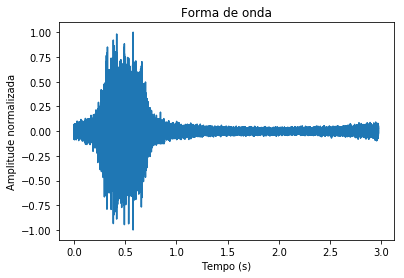

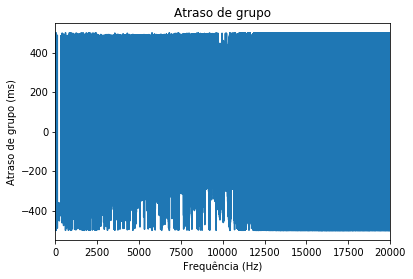

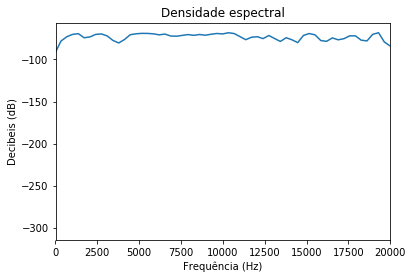

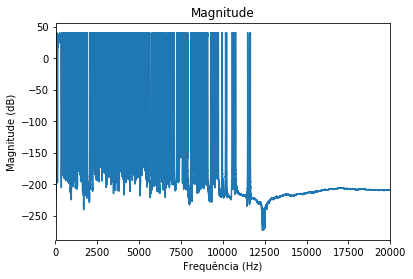

In [14]:
resultByRegularizedDeconvolution = np.roll(normalize(regularizedDeconvolution(ir, tsp, 10)), int(.5*fs))
showSignalInfo(resultByRegularizedDeconvolution)

Finalmente, buscou-se aplicar a técnica de deconvolução de Wiener, que busca uma aproximação $G(f)$ do inverso de uma resposta em frequência $H(f)$ por:

$$G(f) = \frac{H^*(f)}{\left|H(f)\right|^2 + \frac{N(f)}{S(f)}} = \frac{H^*(f)}{\left|H(f)\right|^2 + \frac{1}{SNR(f)}}$$

onde $S(f)$ é a densidade espectral média de potência do sinal de interesse, $N(f)$ a densidade espectral média do ruído a que a operação é submetida e $SNR(f)$ a relação sinal-ruído do sistema, aqui assumida constante e levantada empiricamente.

Esta técnica produziu os melhores resultados tanto de um ponto de vista subjetivo, i.e., de audibilidade, como na reconvolução com a resposta ao impulso da sala, como demonstrado na seção seguinte.

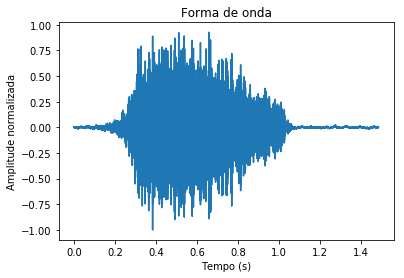

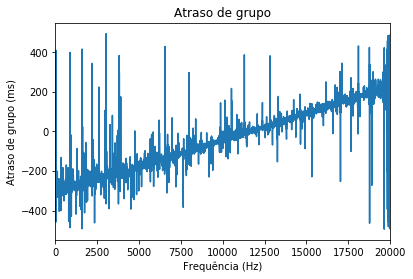

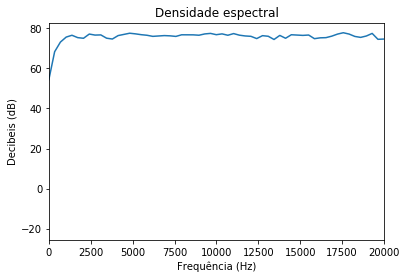

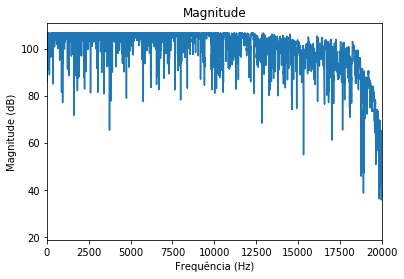

In [15]:
def wienerDeconvolution(signal, kernel, invsnr=10):
    # zero-padding
    kernel = np.pad(kernel, (0, len(signal) - len(kernel)), 'constant')
    H = fft(kernel)
    G = np.conj(H)/(H*np.conj(H) + invsnr**2)
    
    deconvolved = np.real(ifft(fft(signal)*G))
    return deconvolved

resultByWienerDeconvolution = np.roll(wienerDeconvolution(tsp, ir), int(.5*44100))
showSignalInfo(resultByWienerDeconvolution)

## Análise do sinal filtrado quando re-convoluído com a resposta ao impulso da sala

Abaixo encontram-se os resultados da reconvolução de cada um dos TSPs filtrados descritos acima com a resposta ao impulso obtida anteriormente.

* Deconvolução simples:

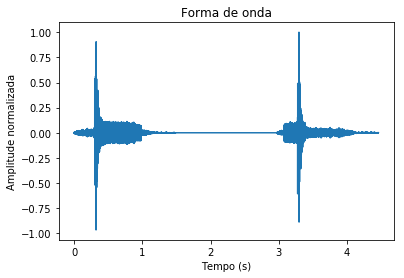

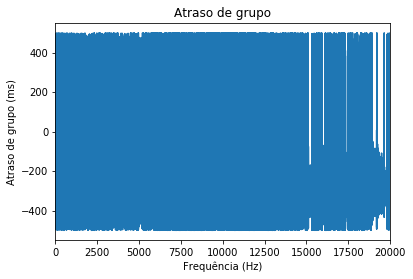

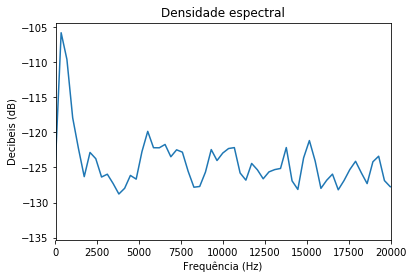

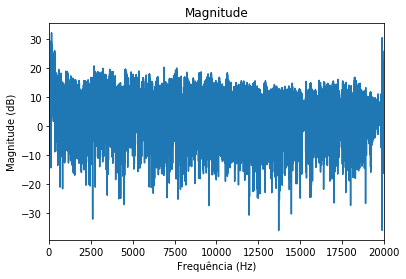

In [17]:
reconvolvedNaiveDeconvolution = scipy.signal.fftconvolve(ir, resultByNaiveDivision)
showSignalInfo(reconvolvedNaiveDeconvolution)

* Divisão do espectro de magnitude:

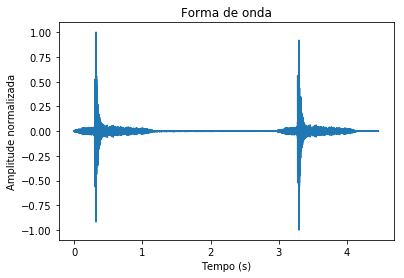

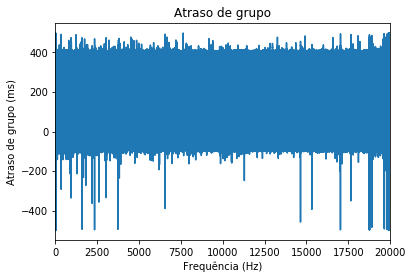

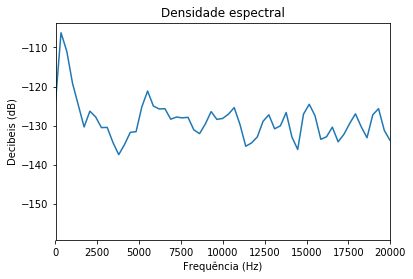

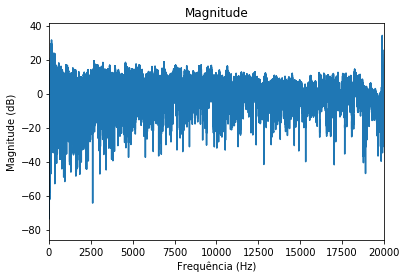

In [18]:
reconvolvedMagnitudeDivision = scipy.signal.fftconvolve(ir, resultByMagnitudeDivision)
showSignalInfo(reconvolvedMagnitudeDivision)

* Deconvolução regularizada:

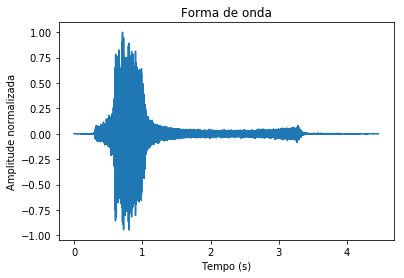

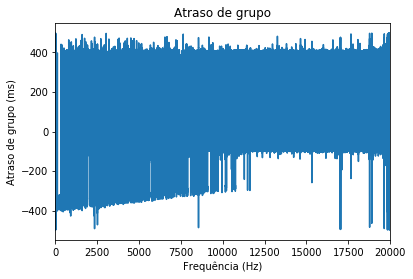

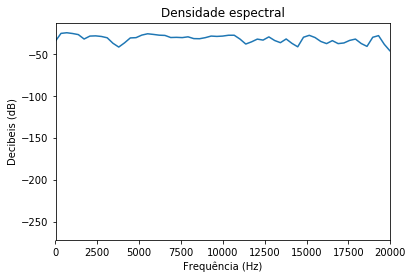

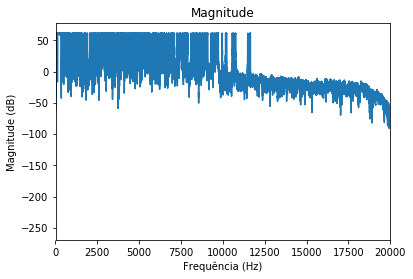

In [19]:
reconvolvedRegularizedDeconvolution = scipy.signal.fftconvolve(ir, resultByRegularizedDeconvolution)
showSignalInfo(reconvolvedRegularizedDeconvolution)

* Deconvolução de Wiener:

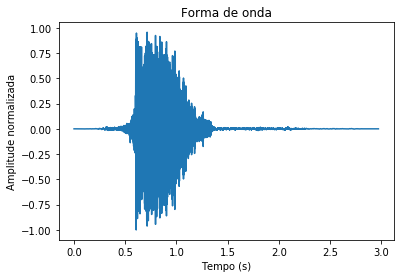

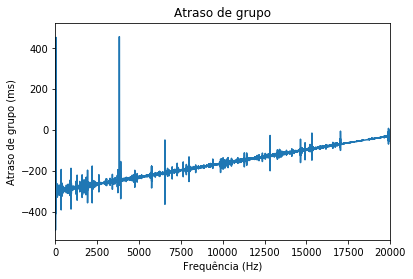

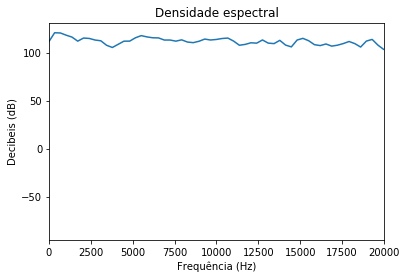

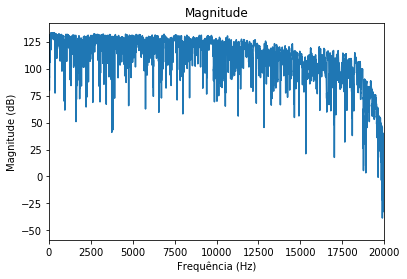

In [20]:
reconvolvedWienerDeconvolution = scipy.signal.fftconvolve(ir, resultByWienerDeconvolution)
showSignalInfo(reconvolvedWienerDeconvolution)

Para fins de referência e comparação, encontra-se reproduzida abaixo a análise da gravação do TSP tocado na sala:

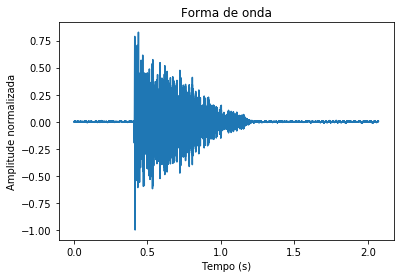

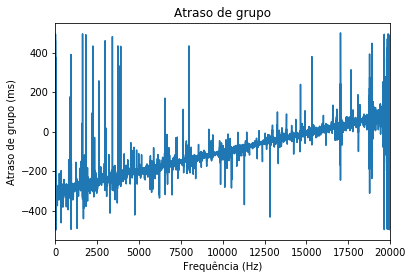

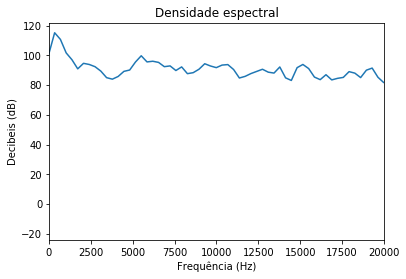

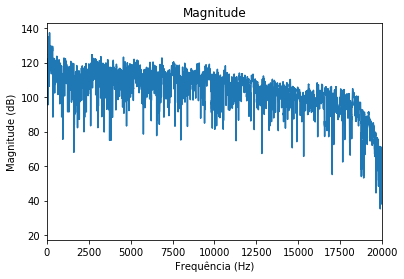

In [21]:
showSignalInfo(recorded)

## Análise do sinal filtrado quando reproduzido na sala

Processed with Wiener deconvolution

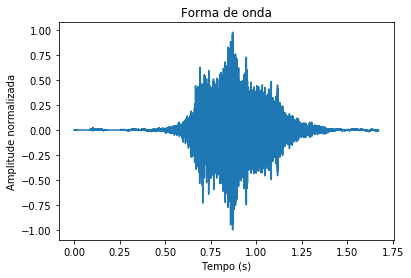

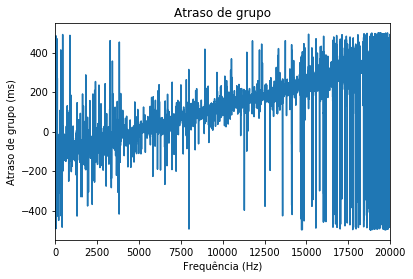

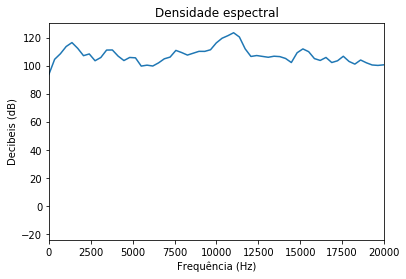

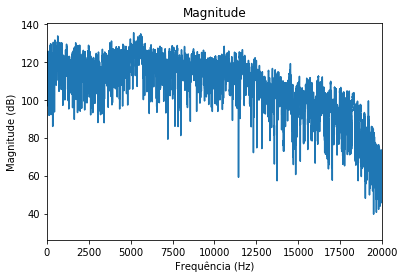

In [40]:
(fs, wiener_recorded) = audioread("../recordings/2017-19-05-paulas-studio/reconvolving-treated-response/wiener_played.wav")
#wiener_recorded = normalize(wiener_recorded)
showSignalInfo(wiener_recorded, fs, signalName="Processed with Wiener deconvolution")

## TSP com espectro de frequência reduzido (500-16k)

TSP from 500 Hz to 16 kHz)

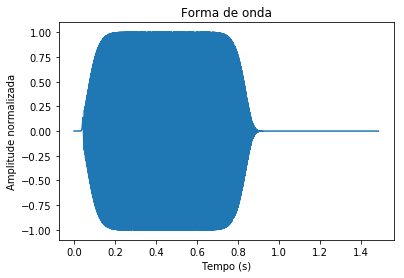

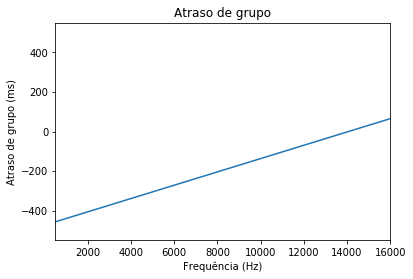

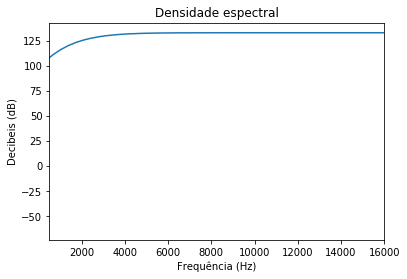

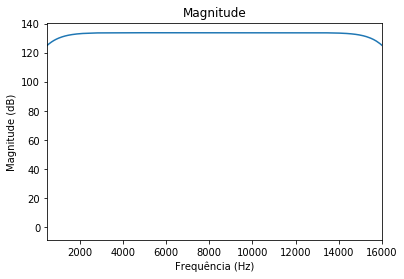

In [30]:
(fs, tsp_filtered) = audioread("../tsp_filtered_500_16k_1s.wav")
#tsp_filtered = normalize(tsp_filtered)
showSignalInfo(tsp_filtered, fs, signalName="TSP from 500 Hz to 16 kHz)", xscale=[500, 16e3])

/usr/local/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


TSP from 500 Hz to 16 kHz (recording)

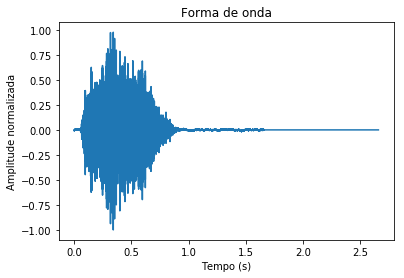

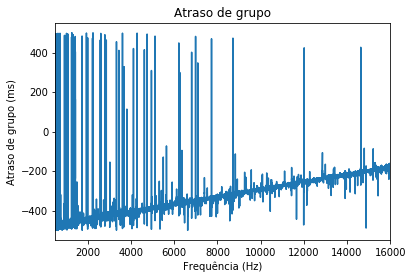

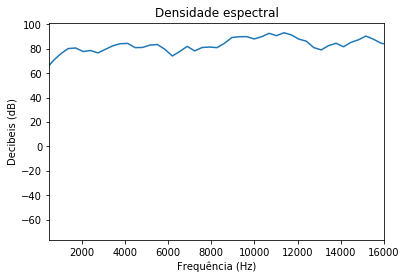

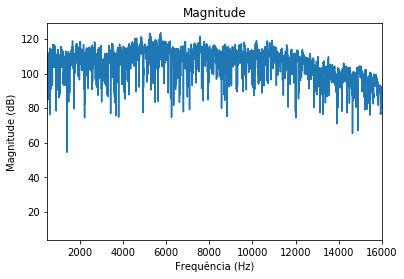

In [31]:
(fs, tsp_rec_filtered) = audioread("../recordings/2017-19-05-paulas-studio/tsp_filtered_rec1.wav")
#tsp_rec_filtered = normalize(tsp_rec_filtered)
showSignalInfo(tsp_rec_filtered, fs, signalName="TSP from 500 Hz to 16 kHz (recording)", xscale=[500, 16e3])

Room impulse response

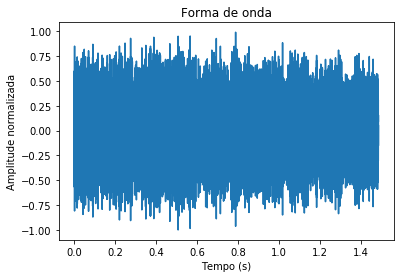

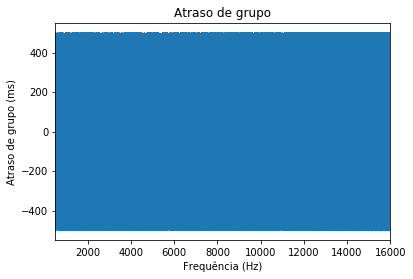

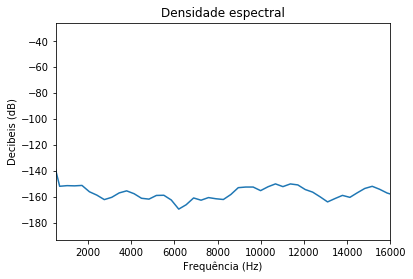

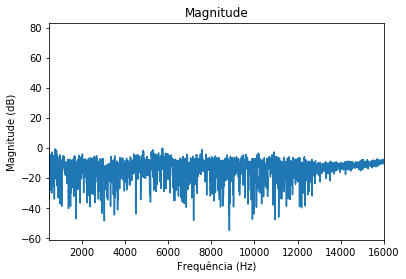

In [36]:
ir_filtered = fftDeconvolve(tsp_filtered, tsp_rec_filtered)
ir_filtered = normalize(ir_filtered)[:len(tsp_filtered)] # truncate the IR
showSignalInfo(ir_filtered, signalName="Room impulse response", xscale=[500,16e3])

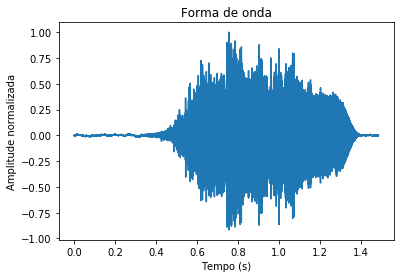

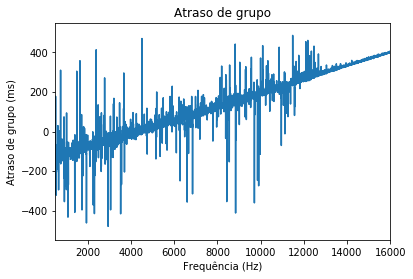

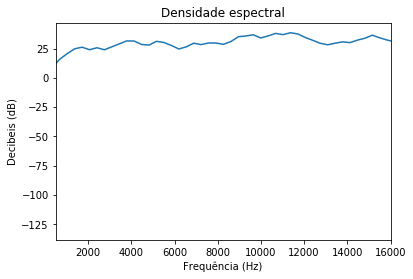

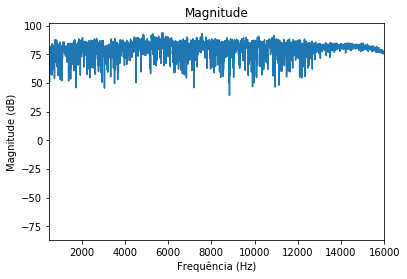

In [38]:
resultByWienerDeconvolution = np.roll(wienerDeconvolution(tsp_filtered, ir_filtered), int(.5*44100))
showSignalInfo(resultByWienerDeconvolution, xscale=[500, 16e3])

/usr/local/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


Processed with Wiener deconvolution

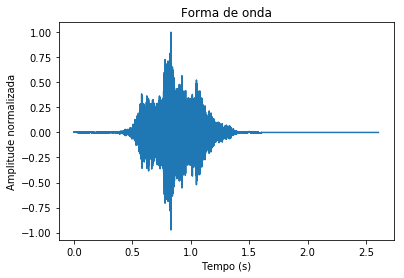

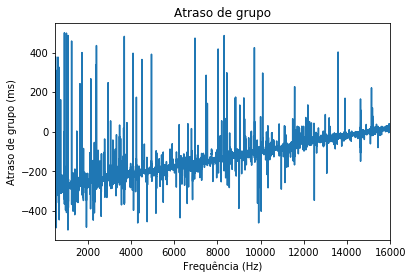

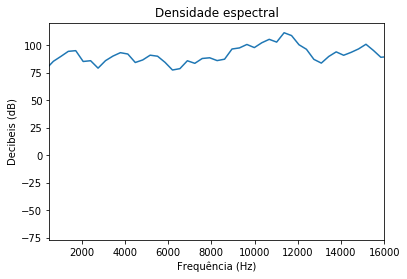

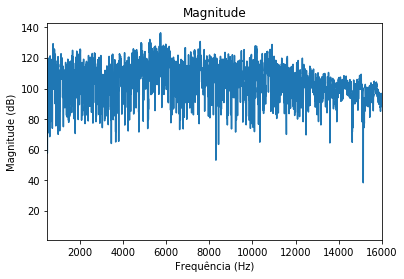

In [39]:
(fs, wiener_filtered_recorded) = audioread("../recordings/2017-19-05-paulas-studio/wiener_filtered_rec3.wav")
#wiener_filtered_recorded = normalize(wiener_filtered_recorded)
showSignalInfo(wiener_filtered_recorded, fs, signalName="Processed with Wiener deconvolution", xscale=[500,16e3])